# Estimating Lithium-ion Battery Health

Based on notebook from https://www.vertica.com/python/examples/battery/.  Extended to include custom models written in keras.

## Background

### Introduction to Lithium-based batteries, their cycles characteristics and aging

### Dataset

In this example of **predictive maintenance**, we propose a data-driven method to estimate the health of a battery using the [Li-ion battery dataset](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/) released by NASA ([csv](../../data/battery5_data.zip)).

This dataset includes information on Li-ion batteries over several charge and discharge cycles at room temperature. Charging was at a constant current (CC) at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. Discharge was at a constant current (CC) level of 2A until the battery voltage fell to 2.7V.

You can download the Jupyter notebook of this study <a href="battery.ipynb">here</a>.

The dataset includes the following:
<ul class="ul_content">
<li><b>Voltage_measured</b>: Battery's terminal voltage (Volts) for charging and discharging cycles</li>
<li><b>Current_measured</b>: Battery's output current (Amps) for charging and discharging cycles</li>
<li><b>Temperature_measured</b>: Battery temperature (degree Celsius)</li>
<li><b>Current_charge</b>: Current measured at charger for charging cycles and at load for discharging cycles (Amps)</li>
<li><b>Voltage_charge</b>: Voltage measured at charger for charging cycles and at load for discharging ones (Volts)</li>
<li><b>Start_time</b>: Starting time of the cycle</li>
<li><b>Time</b>: Time in seconds after the starting time for the cycle (seconds)</li>
<li><b>Capacity</b>: Battery capacity (Ahr) for discharging until 2.7V. Battery capacity is the product of the current drawn from the battery (while the battery is able to supply the load) until its voltage drops lower than a certain value for each cell.</li>
</ul>

## Initialization

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from keras import Input
from keras.layers import Dense
from keras.models import Model

from tensorflow import keras
import tensorflow.compat.v1 as tf
import tensorflow_decision_forests as tfdf
import numpy as np

### Battery5 Dataset Overview

In [2]:
battery5 = pd.read_csv("data/battery5_data.csv")

In [3]:
display(battery5.head(10))

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,type,start_time,ambient_temp,Capacity
0,0.003365,-0.001496,23.369434,0.0000,0.003,2.547,charge,2008-05-28 11:09:42.000045,24,NaN
1,0.236356,-0.003484,23.372048,0.0000,0.003,0.000,charge,2008-05-28 11:09:42.000045,24,NaN
2,2.455679,-2.012590,38.418743,-1.9982,1.685,3250.766,discharge,2008-04-05 22:46:35.000484,24,1.802778
3,2.471315,-2.014389,38.076574,-1.9982,1.695,3270.922,discharge,2008-04-20 15:37:05.000280,24,1.813969
4,2.472448,-2.009283,38.423040,-1.9982,1.684,3290.234,discharge,2008-04-04 09:57:19.000765,24,1.824620
5,2.487927,-2.012423,38.707161,-1.9982,1.692,3308.422,discharge,2008-04-03 17:17:16.000015,24,1.835146
6,2.494240,-2.011439,38.372068,-1.9982,1.712,3251.094,discharge,2008-04-05 18:39:25.000217,24,1.803068
7,2.501080,-2.013083,38.184592,-1.9982,1.719,3292.187,discharge,2008-04-19 23:41:55.000686,24,1.825582
8,2.502776,-2.013330,38.904270,-1.9982,1.709,3331.172,discharge,2008-04-19 02:29:09,24,1.847417
9,2.520948,-2.012970,38.648494,-1.9982,1.720,3309.250,discharge,2008-04-03 12:55:10.000686,24,1.835662


In [4]:
battery5.describe()

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,ambient_temp,Capacity
count,591458.000000,591458.000000,591458.000000,591458.000000,591458.000000,591458.000000,591458.0,50285.000000
mean,4.103945,0.369404,26.369701,0.634476,4.024930,4763.856934,24.0,1.560345
std,0.213469,0.907558,2.772424,0.737029,1.208825,3147.859026,0.0,0.182380
min,0.003365,-4.479660,23.214802,-4.468000,0.000000,0.000000,24.0,1.287453
25%,4.089426,0.040636,24.488485,0.057000,4.240000,1928.175750,24.0,1.386229
50%,4.205140,0.171961,25.479630,0.261000,4.305000,4467.515500,24.0,1.538237
75%,4.205908,1.259778,27.348768,1.498000,4.656000,7503.824000,24.0,1.746871
max,8.393141,1.531301,41.450232,1.998400,5.002000,10807.328000,24.0,1.856487


## Goal and Problem Modeling

Understanding battery health is important, but at the time of writing, there's no direct way to measure it. In our case, we'll create a degredation model to find the relationship between a battery's overall health and the other properties in the dataset, which includes charge and discharge cycle duration, average voltage and current, etc.

One possible definition of the battery's overall health ("state of health" or "SoH") is the following:

Let 

be the rated capacity of the battery when its new (2Ah in our case),
   and  be the actual capacity of the battery at specific time. The
state of health of the battery is defined as:
    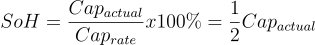

In order to find this relationship, we'll clean and prepare our data by adding some extra features. These extra features will help us understand how the battery behaves during and between each cycle and pinpoint what might be the primary causes for battery degredation.

## Data Exploration

### Data Preparation

Data preparation was done using VerticaPy package following the procedure of original notebook at https://www.vertica.com/python/examples/battery/.  Import from data/battery5_data_processed.csv.  Alternative notebook with VerticaPy code included is also available.

In [5]:
processed_data = pd.read_csv("data/battery5_data_processed.csv")

In [6]:
display(processed_data.head(10))

,start_time,min_temp,max_temp,min_volt,time_to_reach_minvolt,time_to_reach_maxtemp,SOH
0,2008-04-02 15:25:41.000593,0.323720,0.734250,0.013909,1.000000,0.828363,0.928244
1,2008-04-02 19:43:48.000405,0.428584,0.914351,0.002885,0.723648,0.829374,0.923164
2,2008-04-03 00:01:06.000687,0.442661,0.795738,0.053118,0.927548,0.815450,0.917675
3,2008-04-03 04:16:37.000375,0.418765,0.661206,0.053907,0.712097,0.815697,0.917631
4,2008-04-03 08:33:25.000702,0.379861,0.544351,0.041552,0.710988,0.814384,0.917323
5,2008-04-03 12:55:10.000686,0.378615,0.618247,0.009940,0.952280,0.815282,0.917831
6,2008-04-03 17:17:16.000015,0.396431,0.673903,0.010285,0.963926,0.814620,0.917573
7,2008-04-03 21:28:14.000718,0.435977,0.654371,0.027919,0.712817,0.816549,0.912878
8,2008-04-04 01:38:15.000217,0.411844,0.509667,0.055893,0.927842,0.801549,0.912387
9,2008-04-04 05:48:08.000609,0.392347,0.461367,0.062680,0.940644,0.801527,0.912307


In [7]:
#Format and structure data for model input
x_data = processed_data.copy()
x_data = x_data.drop(['start_time','SOH'],axis=1)
y_data = processed_data.copy()
y_data = y_data[['SOH']]

#Convert to numpy array for easier manipulation
x_data = x_data.to_numpy()
y_data = y_data.to_numpy()



In [8]:
#Random shuffle full dataset
data = list(zip(x_data, y_data))
random.shuffle(data)



In [9]:
#Divide into training and testing data
x_data, y_data = zip(*data)
x_train, y_train = np.array(x_data[:100]), np.array(y_data[:100])
x_test, y_test = np.array(x_data[100:]), np.array(y_data[100:])

In [10]:
x_train[:3]

array([[0.22214077, 0.99397836, 0.01741367, 0.420839  , 0.77244488],
       [0.46275852, 0.99595703, 0.32202805, 0.13135311, 0.1280826 ],
       [0.32658276, 0.97103376, 0.13397027, 0.14204242, 0.14073899]])

In [11]:
#Normalize data
data_normalizer = tf.keras.layers.Normalization(input_shape=[5,], axis=None)
data_normalizer.adapt(x_train)
data_normalizer.adapt(x_test)


In [12]:
x_train[:3]

array([[0.22214077, 0.99397836, 0.01741367, 0.420839  , 0.77244488],
       [0.46275852, 0.99595703, 0.32202805, 0.13135311, 0.1280826 ],
       [0.32658276, 0.97103376, 0.13397027, 0.14204242, 0.14073899]])

## Models

### Linear Regression

In [13]:
# data_normalizer = tf.keras.layers.Normalization(input_shape=[5,], axis=None)
# data_normalizer.adapt(x_train)
model_lr = tf.keras.Sequential([
    keras.Input(shape=(5,)),
    tf.keras.layers.Dense(units=1)
])



In [14]:
model_lr.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


### Deep ReLU

In [15]:
inputs = keras.Input(shape=(5,))
x = keras.layers.Dense(20, activation='relu')(inputs)
x = keras.layers.Dense(20, activation='relu')(x)
x = keras.layers.Dense(20, activation='relu')(x)
x = keras.layers.Dense(1, activation='relu')(x)
# x = keras.layers.Dense(1)(x)

model_relu = keras.Model(inputs, x)

# model_relu = tf.keras.Sequential([
#     keras.layers.Dense(20, activation='relu'),
#     keras.layers.Dense(20, activation='relu'),
#     keras.layers.Dense(20, activation='relu'),
#     keras.layers.Dense(1)
# ])

In [16]:
model_relu.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


### Random Forest Regressor

In [17]:
model_rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION,num_trees=100)

### Stacked Sparse Autoencoder (Stacked SAE)

In [18]:
SAE_n_inputs=x_train.shape[1] #--- No. of neurons for the input and output layers
SAE_n_hidden=16 #--- No. of neurons for the hidden layers (including bottleneck)

# Layers
SAE_visible = Input(shape=(5,), name='SAE-Input-Layer') #--- Input-Layer 
SAE_enc_hidden_1 = Dense(units=20, activation='relu', name='SAE-Encoder-Hidden-Layer1')(SAE_visible) #--- Encoder-Hidden-Layer 
SAE_enc_hidden_2 = Dense(units=10, activation='relu', name='SAE-Encoder-Hidden-Layer2')(SAE_enc_hidden_1)
SAE_enc_hidden_3 = Dense(units=5, activation='relu', name='SAE-Encoder-Hidden-Layer3')(SAE_enc_hidden_2)

SAE_bottleneck = Dense(units=SAE_n_hidden, activation='relu', activity_regularizer=keras.regularizers.L1(0.01), name='SAE-Bottleneck-Layer')(SAE_enc_hidden_3) #--- Bottleneck-Layer
SAE_dec_hidden_3 = Dense(units=5, activation='relu', name='SAE-Decoder-Hidden-Layer3')(SAE_bottleneck) #--- Decoder-Hidden-Layer 
SAE_dec_hidden_2 = Dense(units=10, activation='relu', name='SAE-Decoder-Hidden-Layer2')(SAE_dec_hidden_3) #--- Decoder-Hidden-Layer 
SAE_dec_hidden_1 = Dense(units=20, activation='relu', name='SAE-Decoder-Hidden-Layer1')(SAE_dec_hidden_2) #--- Decoder-Hidden-Layer 
# SAE_output = Dense(units=SAE_n_inputs, activation='sigmoid', name='SAE-Output-Layer')(SAE_dec_hidden_1) #--- Output-Layer
SAE_output = Dense(units=1, activation='sigmoid', name='SAE-Output-Layer')(SAE_dec_hidden_1) #--- Output-Layer

# Define Sparse autoencoder model
SAE_model = Model(inputs=SAE_visible, outputs=SAE_output, name='Sparse-Autoencoder-Model')

In [19]:
SAE_model.summary()

Model: "Sparse-Autoencoder-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SAE-Input-Layer (InputLayer) [(None, 5)]               0         
_________________________________________________________________
SAE-Encoder-Hidden-Layer1 (D (None, 20)                120       
_________________________________________________________________
SAE-Encoder-Hidden-Layer2 (D (None, 10)                210       
_________________________________________________________________
SAE-Encoder-Hidden-Layer3 (D (None, 5)                 55        
_________________________________________________________________
SAE-Bottleneck-Layer (Dense) (None, 16)                96        
_________________________________________________________________
SAE-Decoder-Hidden-Layer3 (D (None, 5)                 85        
_________________________________________________________________
SAE-Decoder-Hidden-Layer2 (D (None, 10)   

## Training and Results

### Linear Regression

In [20]:
model_lr.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')
model_lr.fit(x_train, y_train,epochs=100)

Epoch 1/100
4/4 [==============================] - 0s 1ms/step - loss: 0.1540
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 0.1615
Epoch 3/100
4/4 [==============================] - 0s 1ms/step - loss: 0.1180
Epoch 4/100
4/4 [==============================] - 0s 1ms/step - loss: 0.1156
Epoch 5/100
4/4 [==============================] - 0s 1ms/step - loss: 0.0902
Epoch 6/100
4/4 [==============================] - 0s 2ms/step - loss: 0.1092
Epoch 7/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0854
Epoch 8/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0771
Epoch 9/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0662
Epoch 10/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0663
Epoch 11/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0612
Epoch 12/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0468
Epoch 13/100
4/4 [==============================] - 0s 2ms/st

In [21]:
# model_lr.save_weights('models/lr_model')

In [22]:
lr_results = model_lr.predict(x_test)

### Relu

In [23]:
#Fit relu
model_relu.compile(
#     optimizer='Adam',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    #loss=tf.keras.losses.MeanSquaredError(), 
    loss='mean_absolute_error',
#     loss = 'mean_absolute_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model_relu.fit(x_train, y_train,epochs=100)
# model_relu.save_weights('models/relu_model')

Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 0.3194 - root_mean_squared_error: 0.3907
Epoch 2/100
4/4 [==============================] - 0s 2ms/step - loss: 0.1241 - root_mean_squared_error: 0.1470
Epoch 3/100
4/4 [==============================] - 0s 2ms/step - loss: 0.1085 - root_mean_squared_error: 0.1271
Epoch 4/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0860 - root_mean_squared_error: 0.1014
Epoch 5/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0943 - root_mean_squared_error: 0.1039
Epoch 6/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0735 - root_mean_squared_error: 0.0848
Epoch 7/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0442 - root_mean_squared_error: 0.0539
Epoch 8/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0381 - root_mean_squared_error: 0.0475
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0400 - root_mean_squared_error:

In [24]:
relu_results = model_relu.predict(x_test)

### Random Forest Regression


In [25]:
model_rf.fit(x_train,y_train)

4/4 [==============================] - 3s 1ms/step


In [26]:
rf_results = model_rf.predict(x_test)

### Stacked SAE

In [28]:
SAE_model.compile(optimizer='adam',loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [29]:
SAE_model.fit(x_train, y_train, epochs=100,)

Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0978 - root_mean_squared_error: 0.3012
Epoch 2/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0940 - root_mean_squared_error: 0.2978
Epoch 3/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0901 - root_mean_squared_error: 0.2937
Epoch 4/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0862 - root_mean_squared_error: 0.2889
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0823 - root_mean_squared_error: 0.2839
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0786 - root_mean_squared_error: 0.2785
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0751 - root_mean_squared_error: 0.2723
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0713 - root_mean_squared_error: 0.2649
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0669 - root_mean_squared_error:

In [ ]:
#SAE_model.save_weights('models/sae_model')

In [30]:
sae_results = SAE_model.predict(x_test)

### Results

Now that we have the results for each model, we can plot the predicted values against the actual test value to visualize the performance comparision.

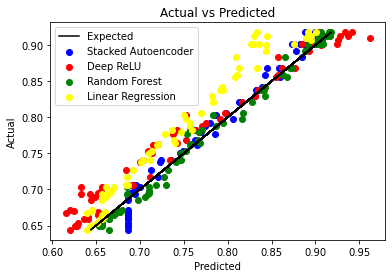

In [45]:
plt.scatter(sae_results,y_test , c='blue',label='Stacked Autoencoder')
plt.scatter(relu_results,y_test , c='red',label='Deep ReLU')
plt.scatter(rf_results,y_test , c='green',label='Random Forest')
plt.scatter(lr_results,y_test , c='yellow',label='Linear Regression')
plt.plot(y_test, y_test, c='black',label='Expected')
# x = [5,6,7,8]
# y = [1,3,5,2]

# plt.scatter(x, y, c='lightblue')

plt.title('Actual vs Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend()
# plt.savefig('ScatterPlot_05.png')
plt.show()

We can further compare the results of the different models on the testing set using two common performance metrics: Mean Absolute Percentage Error (MAPE) and Root Mean Square Error (RMSE).

MAPE is expressed by:
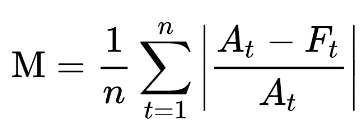
RMSE is expressed by:
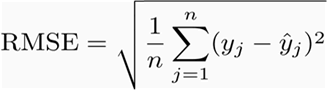

We additionally multiply MAPE by 100 to get the performance as a percentage.  


In [43]:
#Mean Absolute Percentage Error (MAPE)
results = {
    'Linear Regression': lr_results,
    'Deep ReLU':relu_results,
    'Random Forest': rf_results,
    'Stacked SAE': sae_results,
}
df_results = pd.DataFrame(columns=['Model', 'MAPE','RMSE'])
for name, y_predict in results.items():
    mape = 100* np.mean(abs((y_test - y_predict) / y_test), axis=0)[0] #*100
    rmse = np.sqrt(np.mean(np.square(y_test - y_predict)))
    df_results = df_results.append({'Model':name, 'MAPE':mape, 'RMSE':rmse},ignore_index=True)
#     print(tf.keras.losses.mean_absolute_percentage_error(y_test, y_predict))

In [44]:
display(df_results)

,Model,MAPE,RMSE
0,Linear Regression,4.389220,0.040527
1,Deep ReLU,3.186400,0.029356
2,Random Forest,1.037114,0.010038
3,Stacked SAE,1.765529,0.016597


From the above table, we can see that the random forest regressor and SAE models perform best overall of the models we implemented.  It is worth noting that SAE's for test data with actual values below 0.68 is particularly skewed, which we can improve through additional data or likely by adjusting the learning rate.